## Import Semua Library

In [1]:
import pandas as pd
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
import os.path 

## Fungsi Menampilkan Gambar

In [2]:
def showImg(img):
    plt.figure(figsize=(20,20))
    for i in range(len(img)):
        plt.subplot(1,len(img),i+1)
        plt.imshow(img[i], cmap='gray')

## Mengakses Semua File Dalam Folder

In [3]:
def inserImg(folder):
    data = []
    filenames = []
    labels = []
    for label in os.listdir(folder):
        for filename in os.listdir(folder+"/"+label):
            labels.append(label)
            img = cv.imread(os.path.join(folder+"/"+label,filename))
            print(os.path.join(folder+"/"+label,filename))
            filenames.append(filename)
            if img is not None:
                data.append(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    return data, filenames, labels


In [4]:
images, filename, labels = inserImg("traffic_light_data/train/")

traffic_light_data/train//back\back_1.png
traffic_light_data/train//back\back_10.png
traffic_light_data/train//back\back_100.png
traffic_light_data/train//back\back_101.png
traffic_light_data/train//back\back_102.png
traffic_light_data/train//back\back_103.png
traffic_light_data/train//back\back_104.png
traffic_light_data/train//back\back_105.png
traffic_light_data/train//back\back_106.png
traffic_light_data/train//back\back_107.png
traffic_light_data/train//back\back_108.png
traffic_light_data/train//back\back_109.png
traffic_light_data/train//back\back_11.png
traffic_light_data/train//back\back_110.png
traffic_light_data/train//back\back_111.png
traffic_light_data/train//back\back_112.png
traffic_light_data/train//back\back_113.png
traffic_light_data/train//back\back_114.png
traffic_light_data/train//back\back_115.png
traffic_light_data/train//back\back_116.png
traffic_light_data/train//back\back_117.png
traffic_light_data/train//back\back_118.png
traffic_light_data/train//back\back_

## Resize Gambar dengan Ukuran 300px, 500px

In [5]:
def resize(image):
    result = cv.resize(image, (300, 500), interpolation=cv.INTER_CUBIC)
    return result

## Normalisasi Semua Pixel Gambar dalam Folder

In [6]:
normalize = []
for image in images:
    image = cv.normalize(image, None, alpha=0,beta=255, norm_type=cv.NORM_MINMAX)
    normalize.append(resize(image))

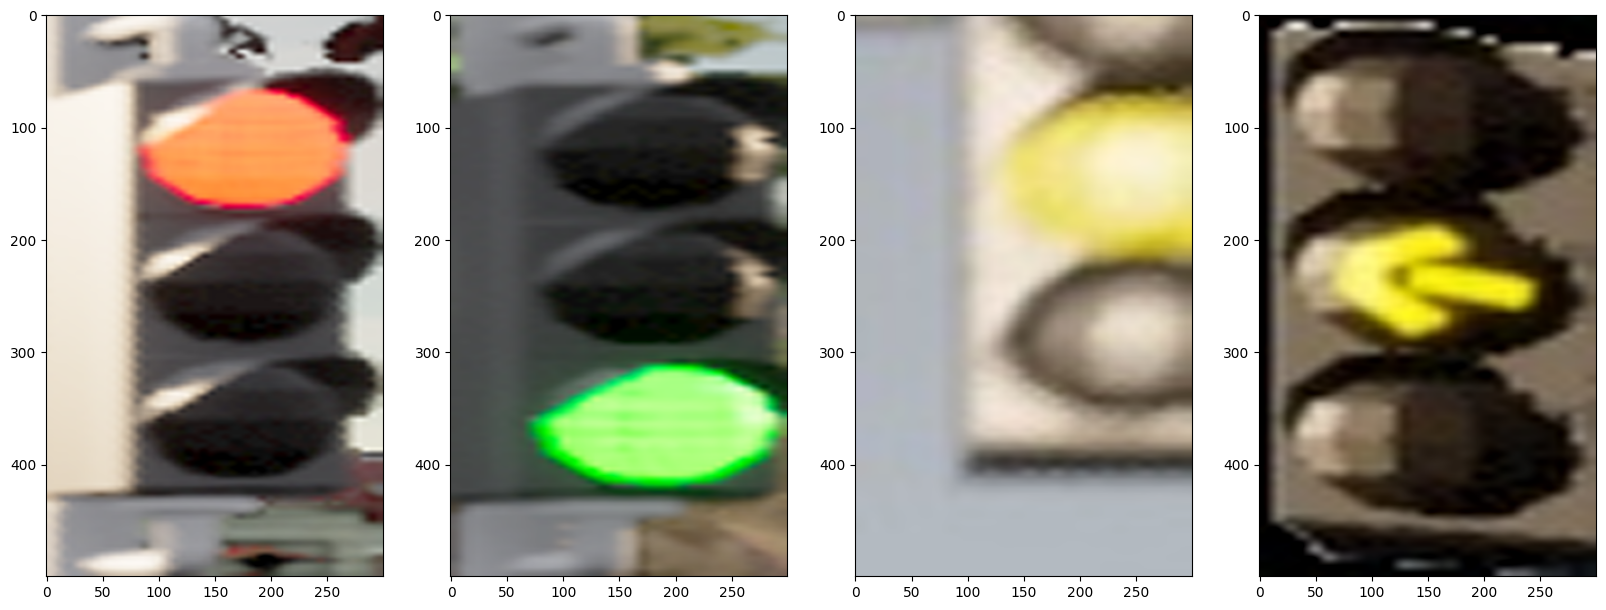

In [7]:
showImg([normalize[1100],normalize[1000],normalize[1850],normalize[2000]])

## Melakukan Pengurangan Derau dengan Metode Penapis Gaussian

In [8]:
gaussians = []
for blurred in normalize:
    blurred = cv.GaussianBlur(blurred, (5, 5), 1)
    gaussians.append(blurred)

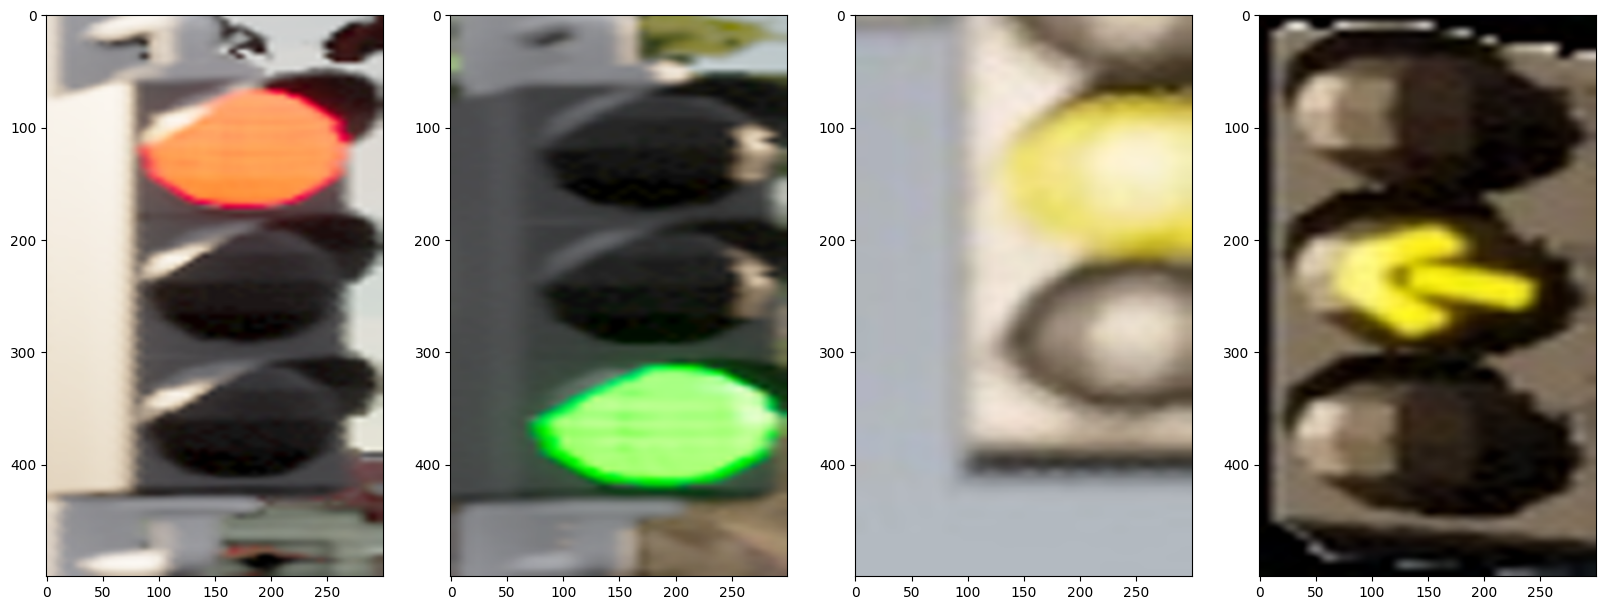

In [9]:
showImg([gaussians[1100],gaussians[1000],gaussians[1850],gaussians[2000]])

In [10]:
def green(img): 
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    mask = cv.inRange(hsv, (40, 40, 40), (70, 255,255))
    imask = mask>0
    hasil = np.zeros_like(img, np.uint8)
    hasil[imask] = img[imask]

    return hasil

def red(img):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    mask = cv.inRange(hsv, (0, 100, 20), (179, 255,255))
    imask = mask>0
    hasil = np.zeros_like(img, np.uint8)
    hasil[imask] = img[imask]

    return hasil

def yellow(img):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    mask = cv.inRange(hsv, (23,93,0), (40,255,255))
    imask = mask>0
    hasil = np.zeros_like(img, np.uint8)
    hasil[imask] = img[imask]

    return hasil

def segment(image):
    return green(image)+red(image)+yellow(image)

In [11]:
segments = []
for segmentColor in gaussians:
    segments.append(segment(segmentColor))

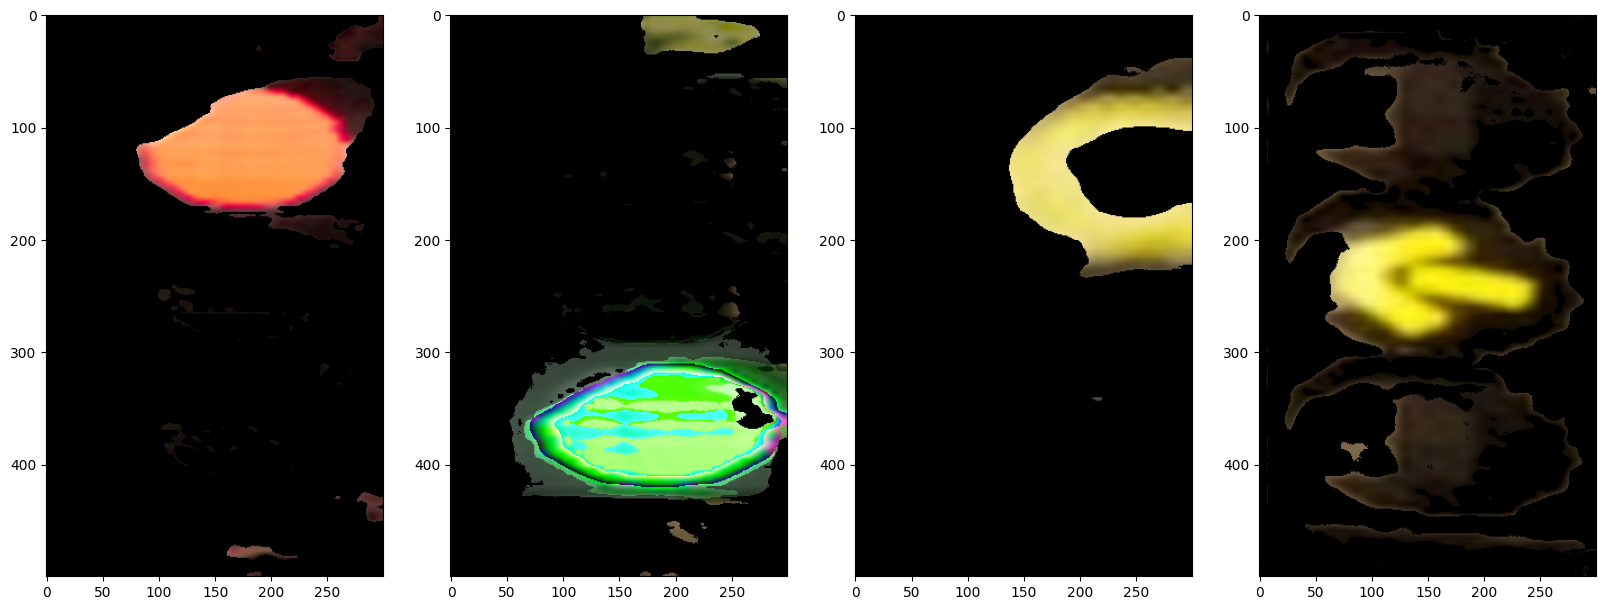

In [12]:
showImg([segments[1100],segments[1000],segments[1850],segments[2000]])

In [13]:
edges = []
for edge in segments:
    edge = cv.Canny(edge, 50, 0)
    edges.append(edge)

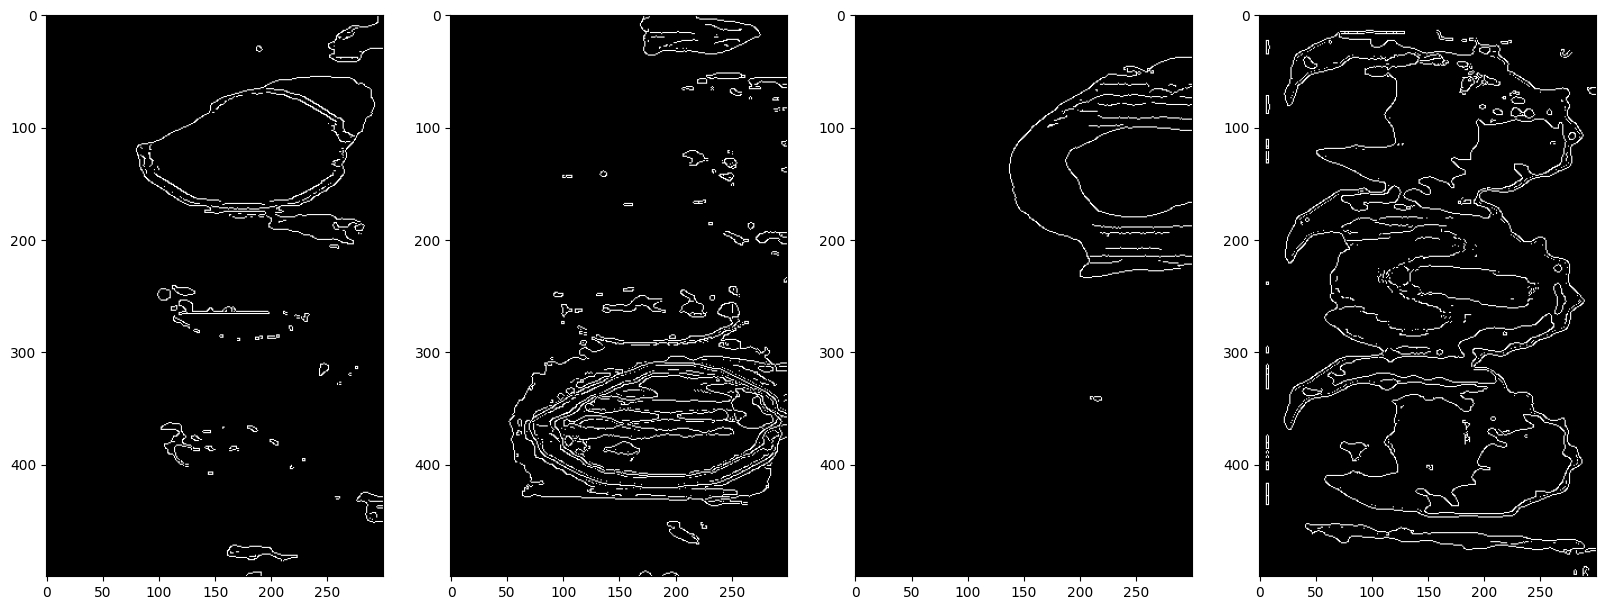

In [14]:
showImg([edges[1100],edges[1000],edges[1850],edges[2000]])

In [15]:
def selectedEdge(image):
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv.dilate(image, kernel, iterations=1)
    eroded = cv.erode(dilated, kernel, iterations=1)
    contours, _ = cv.findContours(eroded, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    selected_edges = np.zeros_like(eroded)

    image_area = image.shape[0] * image.shape[1]
    min_area_ratio = 0.0005
    max_area_ratio = 0.02
    min_area = int(min_area_ratio * image_area)
    max_area = int(max_area_ratio * image_area)

    for contour in contours:
        area = cv.contourArea(contour)
        if min_area < area < max_area:
            cv.drawContours(selected_edges, [contour], -1, (255), thickness=cv.FILLED) 
    return selected_edges


In [16]:
selected = []
for select in edges:
    select = selectedEdge(select)
    selected.append(select)

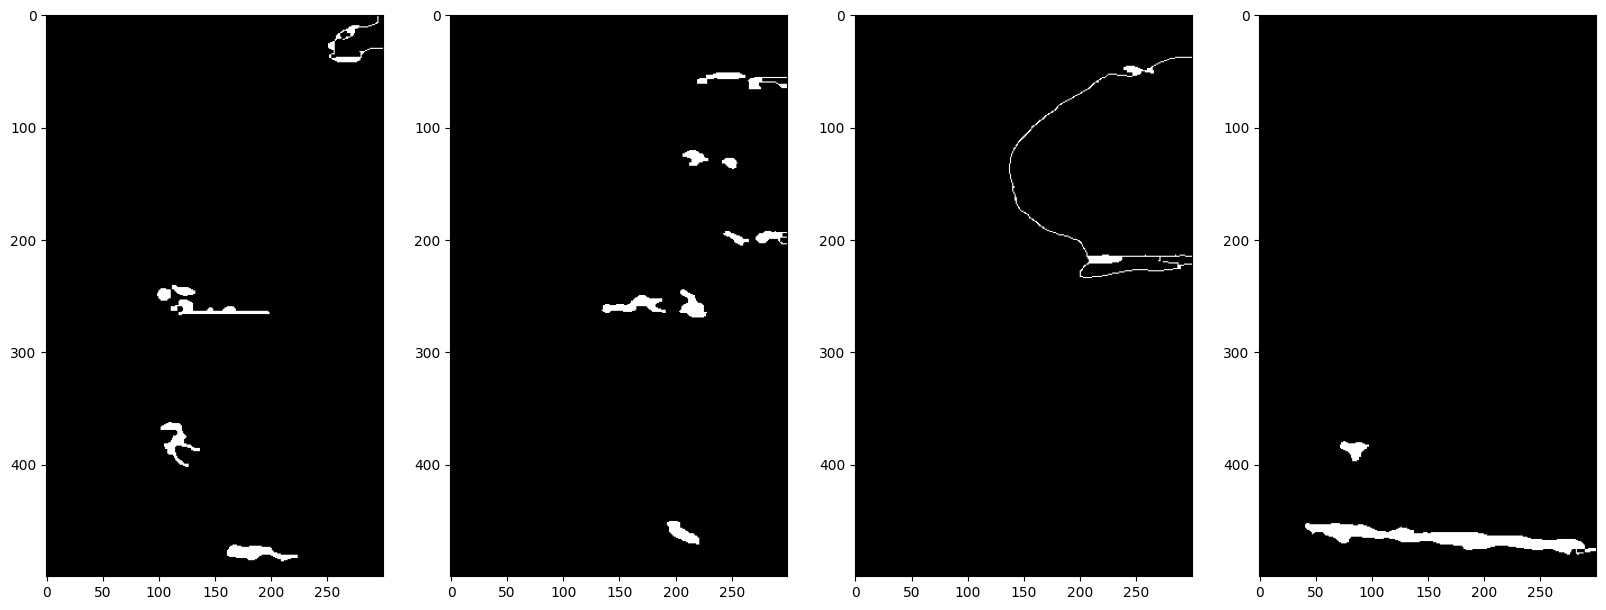

In [17]:
showImg([selected[1100],selected[1000],selected[1850],selected[2000]])


In [18]:
masked = []
for index, mask in enumerate(edges):
    # Mengakses gambar dengan indeks yang sama
    img = normalize[index]

    # Mengaplikasikan bitwise_and pada gambar dan mask
    masked_img = cv.bitwise_and(img, img, mask=mask)

    # Menyimpan masked_img ke dalam daftar masked
    masked.append(masked_img)


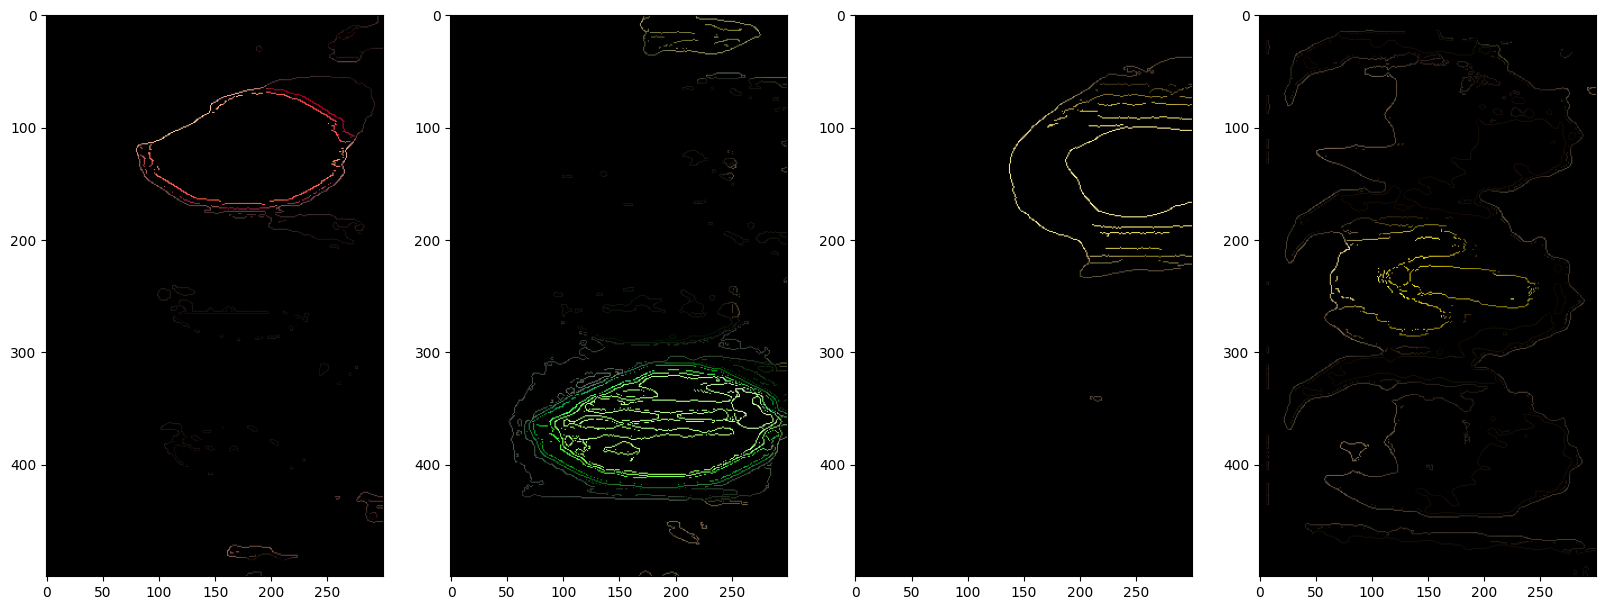

In [19]:
showImg([masked[1100],masked[1000],masked[1850],masked[2000]])

In [20]:
def color_selection(image):
    hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    
    hue_channel = hsv_image[:, :, 0]
    
    mask = np.logical_and(hue_channel >= 0, hue_channel <= 150)
    
    result = np.zeros_like(image)
    result[mask] = image[mask]
    
    return result

In [21]:
colorSelection = []
for color in masked:
    color = color_selection(color)
    colorSelection.append(color)

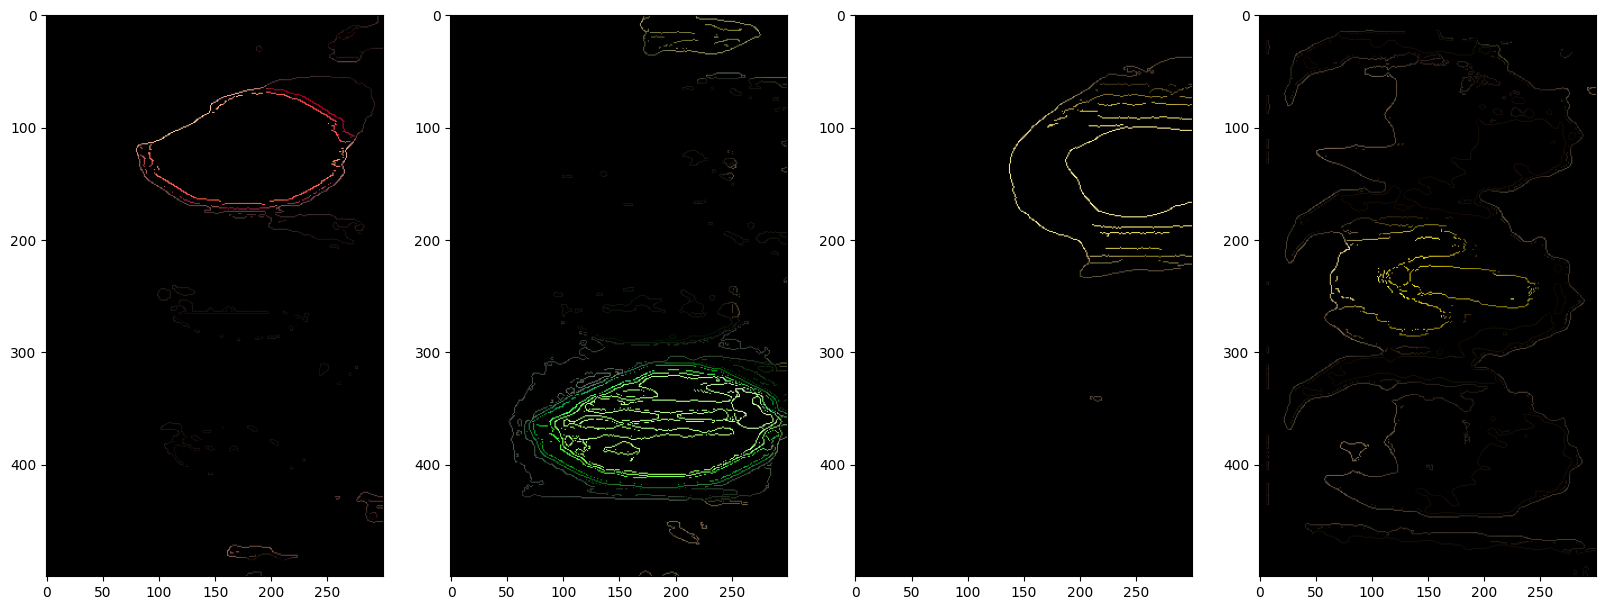

In [22]:
showImg([colorSelection[1100],colorSelection[1000],colorSelection[1850],colorSelection[2000]])

In [32]:
def detect_color(hue):
    if hue < 30:
        return "Merah"
    elif hue > 90:
        return "Hijau"
    else:
        return "Kuning"

def detect_color_location(image_path):
    # Mengubah ruang warna gambar dari BGR ke HSV
    hsv_image = cv.cvtColor(image_path, cv.COLOR_BGR2HSV)
    
    # Menentukan range nilai Hue untuk masing-masing warna
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([30, 255, 255])
    
    lower_green = np.array([40, 40, 40])
    upper_green = np.array([150, 255, 255])
    
    lower_yellow = np.array([30, 100, 100])
    upper_yellow = np.array([90, 255, 255])
    
    # Membuat mask untuk setiap warna
    red_mask = cv.inRange(hsv_image, lower_red, upper_red)
    green_mask = cv.inRange(hsv_image, lower_green, upper_green)
    yellow_mask = cv.inRange(hsv_image, lower_yellow, upper_yellow)
    
    # Menemukan kontur objek yang terdeteksi
    contours, _ = cv.findContours(red_mask + green_mask + yellow_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    # Memberi nilai default untuk detected_color
    detected_color = None
    
    # Mengiterasi setiap kontur objek yang terdeteksi
    for contour in contours:
        # Menghitung luas kontur
        area = cv.contourArea(contour)
        
        # Mengabaikan objek kecil yang mungkin bukan warna yang diinginkan
        if area > 100:
            # Menghitung momen kontur
            M = cv.moments(contour)
            
            # Menghitung centroid objek
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            
            # Menghitung nilai rata-rata Hue dari area yang terdeteksi
            masked_hsv_image = cv.cvtColor(hsv_image, cv.COLOR_HSV2BGR)
            hue = masked_hsv_image[cy, cx][0]
            
            # Mendeteksi warna berdasarkan nilai Hue
            detected_color = detect_color(hue)
        
        # Memberi label warna pada objek yang terdeteksi jika detected_color sudah memiliki nilai
        if detected_color is not None:
            # Menentukan warna tulisan berdasarkan warna yang terdeteksi
            if detected_color == "Merah":
                text_color = (179, 255,255)  # Merah
            elif detected_color == "Hijau":
                text_color = (70, 255,255)  # Hijau
            else:
                text_color = (40,255,255)  # Kuning
            
            cv.putText(image_path, detected_color, (cx, cy), cv.FONT_HERSHEY_SIMPLEX, 1, text_color, 2)

    return image_path

In [33]:
resultColor = []
for result in segments:
    result = detect_color_location(result)
    resultColor.append(result)

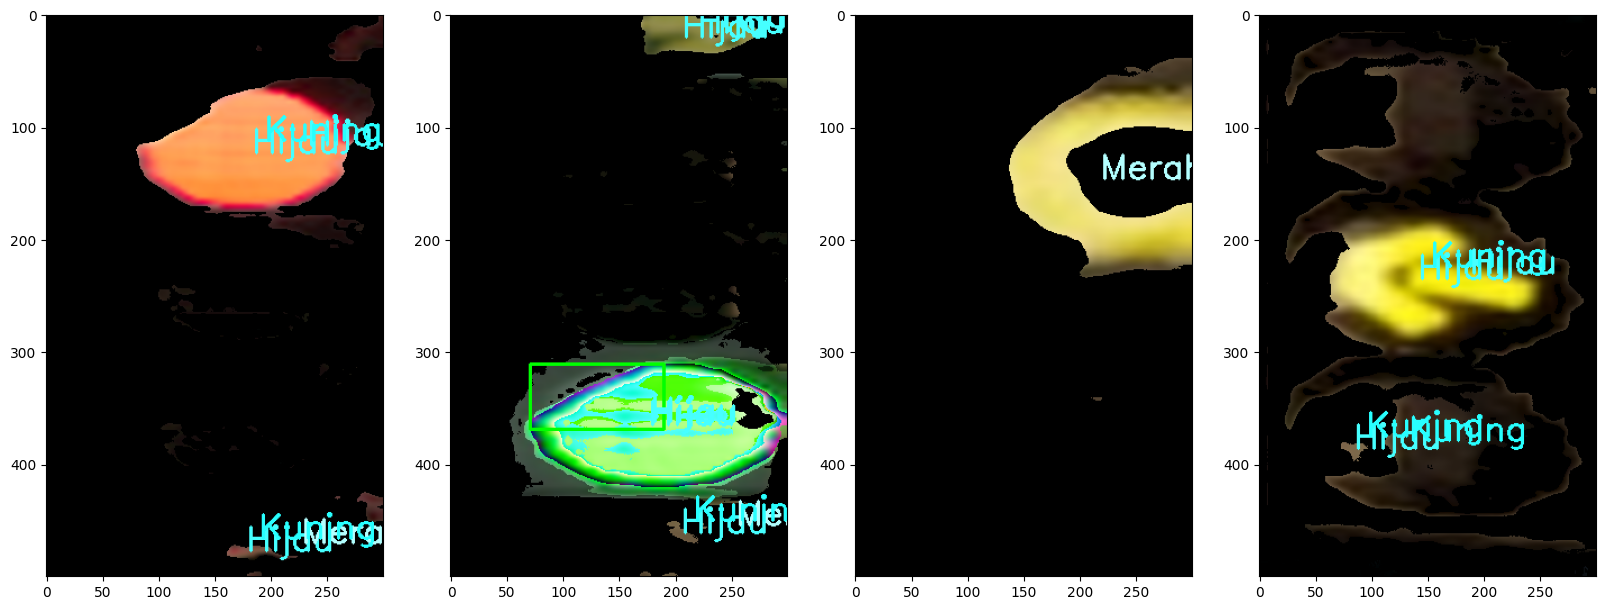

In [34]:
showImg([resultColor[1100],resultColor[1000],resultColor[1850],resultColor[2000]])